# Some aspects of performance in image processing

Image processing on scientific data can take a long time, especially in settings where a series of images are acquired (time series for example). It is sometimes desirable to reduce the run-time of a given image processing pipeline, for example to make real-time image processing possible. 

In this tutorial, we cover several aspects of this specific task.

## Measuring computing times and profiling

If you want to optimize execution time, you first need to measure it. 

In [1]:
from skimage import data
import numpy as np
img = data.eagle()
print(img.shape)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


(2019, 1826)


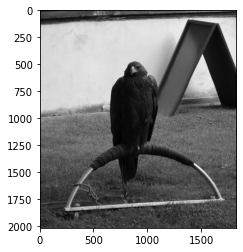

In [2]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')

In [3]:
%%timeit
from skimage import filters
img_median = filters.median(img, footprint=np.ones((7, 7), dtype=bool))

1.88 s ± 56.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
from time import time
from skimage import filters
t1 = time()
img_median = filters.median(img, footprint=np.ones((7, 7), dtype=bool))
t2 = time()
print(t2 - t1)

2.046349287033081


Now we know the time taken by a given function, but we don't know why it should take a long time to execute. We can use Python's line profile to dive into the inner code of a function, and to identify which lines of the function take longer to execute.

In [5]:
from skimage import color
img = color.rgb2gray((data.retina()[300:-300, 300:-300]))
out = filters.hessian(img)

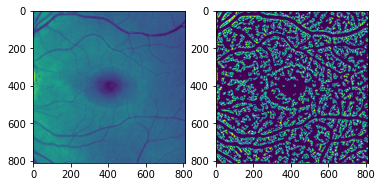

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(out)

In [7]:
from line_profiler import LineProfiler, show_func
profile = LineProfiler()
profile.add_function(filters.hessian)

In [8]:
out = profile.runcall(filters.hessian, img)

In [9]:
profile.print_stats()

Timer unit: 1e-06 s

Total time: 0.481012 s
File: /home/emma/Documents/scikit-image/skimage/filters/ridges.py
Function: hessian at line 472

Line #      Hits         Time  Per Hit   % Time  Line Contents
   472                                           def hessian(image, sigmas=range(1, 10, 2), scale_range=None, scale_step=None,
   473                                                       alpha=0.5, beta=0.5, gamma=15, black_ridges=True, mode='reflect',
   474                                                       cval=0):
   475                                               """Filter an image with the Hybrid Hessian filter.
   476                                           
   477                                               This filter can be used to detect continuous edges, e.g. vessels,
   478                                               wrinkles, rivers. It can be used to calculate the fraction of the whole
   479                                               image containing such

**Exercise**: what is the function taking the largest part of the execution time inside ``hessian``? Add this function to the line profiler and line-profile this other function while executing ``hessian``.

It is of course possible to apply the line profiler to your own functions. This can be useful when defining for example an image processing pipeline with a succession of operations. 

In [10]:
%load_ext line_profiler

In [11]:
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

def get_labels(img):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(5))
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    # label image regions
    label_image = label(cleared)
    return label_image

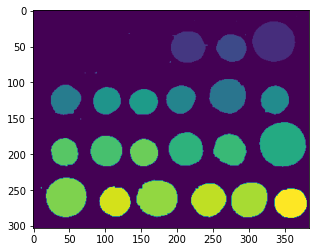

In [12]:
image = data.coins()

labels = get_labels(img)
plt.imshow(labels)

In [13]:
%lprun -f get_labels get_labels(img)

scikit-image uses a lot of cython code, and it is also possible to profile cython code. Please see https://cython.readthedocs.io/en/latest/src/tutorial/profiling_tutorial.html for more information.

## Parallelizing execution by chunking the image array

One way to speed up the execution is to use the different CPU cores. Most scikit-image functions use only one core, so the other cores are not working. If we have several images, we can use different cores for the different images (using for example ``joblib.Parallel`` or ``dask``). But we can also divide the image into different sub-images and execute the function on the different sub-images. This is done by ``skimage.util.apply_parallel``.

**Warning**: most functions have boundary effects. Therefore you must use some overlap between the different sub-images in order to avoid artifacts.

In [14]:
img = data.eagle()
print(img.shape)

(2019, 1826)


In [15]:
from time import time
t1 = time()
out = filters.median(img, np.ones((11, 11)))
t2 = time()
print(t2 - t1)

4.173186302185059


In [16]:
import joblib
joblib.cpu_count()

4

In [17]:
from skimage import util
t1 = time()
out = util.apply_parallel(filters.median, img, depth=7, extra_arguments=[np.ones((11, 11))])
t2 = time()
print(t2 - t1)

1.9920413494110107


In [18]:
from skimage import util
t1 = time()
out = util.apply_parallel(filters.median, img, chunks=500, depth=7, extra_arguments=[np.ones((11, 11))])
t2 = time()
print(t2 - t1)

1.9505162239074707


**Exercise**: try different sizes of chunks and compare the execution times.

## Changing the algorithm

Often, the biggest performance gains are obtained by using a different algorithm. There is often a tradeoff between execution time and algorithm specificity, as exemplified by the example below about denoising. (Example adapted from https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise.html#sphx-glr-auto-examples-filters-plot-denoise-py).

TV: 0.07958173751831055 s
Non-local means: 0.1718578338623047 s
Bilateral: 2.8190791606903076 s
Estimated Gaussian noise standard deviation = 0.14868785032269857


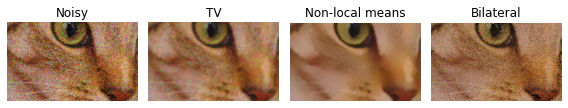

In [19]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, denoise_nl_means, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from time import time

original = img_as_float(data.chelsea()[100:250, 50:300])

sigma = 0.155
noisy = random_noise(original, var=sigma**2)

t0 = time()
img_tv = denoise_tv_chambolle(noisy, weight=0.1, channel_axis=-1)
t1 = time()
print(f"TV: {t1 - t0} s" )

t0 = time()
img_nlmeans = denoise_nl_means(noisy,
                channel_axis=-1)
t1 = time()
print(f"Non-local means: {t1 - t0} s")

t0 = time()
img_bil = denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=11,
                channel_axis=-1)
t1 = time()
print(f"Bilateral: {t1 - t0} s")


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Noisy')
ax[1].imshow(img_tv)
ax[1].axis('off')
ax[1].set_title('TV')
ax[2].imshow(img_nlmeans)
ax[2].axis('off')
ax[2].set_title('Non-local means')
ax[3].imshow(img_bil)
ax[3].axis('off')
ax[3].set_title('Bilateral')


fig.tight_layout()

plt.show()
